In [6]:
# Data manipulation and analysis
import pandas as pd
import numpy as np
import pickle
import time

from matplotlib import pyplot as plt

from scipy import stats
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score
import concurrent.futures
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim

# Custom imports
from GEMS_TCO import orbitmap
from GEMS_TCO import kernels

In [7]:

print(pd.__version__)
print(np.__version__)

2.2.2
2.0.0


Initiate instsance

In [2]:
df = pd.read_csv("C:\\Users\\joonw\\TCO\\data_engineering\\data_2024\\data_24_07_0131_N510_E110120.csv")
instance = orbitmap.MakeOrbitdata(df, 5,10,110,120)

# Load the dictionary from the pickle file
filepath = "C:\\Users\\joonw\\TCO\\data_engineering\\data_2024\\sparse_cen_map24_01.pkl"

with open(filepath, 'rb') as pickle_file:
    coarse_dict_24_1 = pickle.load(pickle_file)

sample_df = coarse_dict_24_1['y24m01day01_hm02:12']

Set coarse coordinates

In [3]:
rho_lat = 20
rho_lon = 20
lat_n = sample_df['Latitude'].unique()[::rho_lat]
lon_n = sample_df['Longitude'].unique()[::rho_lon]

print(len(lat_n))
print(len(lon_n))

5
10


Note that

# Efficiency: isin is vectorized, leveraging pandas' optimized internals for filtering
# tr  = ddf.apply(lambda x: (x.Latitude in lat_n) and (x.Longitude in lon_n), axis=1) 

In [4]:
# Set coarse coordinates


coarse_dicts = {}

years = ['2023','2024']
for year in years:
    for month in range(1, 13):  # Iterate over all months
        filepath = f"C:\\Users\\joonw\\TCO\\data_engineering\\data_{year}\\sparse_cen_map{year[2:]}_{month:02d}.pkl"
        with open(filepath, 'rb') as pickle_file:
            loaded_map = pickle.load(pickle_file)
            for key in loaded_map:
                tmp_df = loaded_map[key]
                coarse_filter = (tmp_df['Latitude'].isin(lat_n)) & (tmp_df['Longitude'].isin(lon_n))
                coarse_dicts[f"{year}_{month:02d}_{key}"] = tmp_df[coarse_filter].reset_index(drop=True)

        print(f"Finished processing {year} {month}.")


Finished processing 2023 1.
Finished processing 2023 2.
Finished processing 2023 3.
Finished processing 2023 4.
Finished processing 2023 5.
Finished processing 2023 6.
Finished processing 2023 7.
Finished processing 2023 8.
Finished processing 2023 9.
Finished processing 2023 10.
Finished processing 2023 11.
Finished processing 2023 12.
Finished processing 2024 1.
Finished processing 2024 2.
Finished processing 2024 3.
Finished processing 2024 4.
Finished processing 2024 5.
Finished processing 2024 6.
Finished processing 2024 7.
Finished processing 2024 8.
Finished processing 2024 9.
Finished processing 2024 10.
Finished processing 2024 11.
Finished processing 2024 12.


Efficiency: Reduces memory overhead and improves runtime performance.

For large-scale DataFrame concatenation, the list-based approach is the preferred way to go. Your adjusted code will be both faster and more robust!

In [5]:
df_list = []

for key in coarse_dicts:
    df_list.append(coarse_dicts[key])

df_entire = pd.concat(df_list, axis=0, ignore_index=True)


Step 1: Pretrained CNN for Feature Extraction
The CNN processes spatial grids (latitude × longitude) and outputs flattened features.

In [82]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import numpy as np
import pandas as pd
import torch.optim as optim

class FeatureExtractorCNN(nn.Module):
    def __init__(self, cnn_channels, output_size):
        super(FeatureExtractorCNN, self).__init__()
        self.conv1 = nn.Conv2d(cnn_channels, 16, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.fc = nn.Linear(64 * 5 * 10, output_size)  # Adjust based on grid size (5 × 10 here)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        x = x.view(x.size(0), -1)  # Flatten
        x = self.fc(x)
        return x


Step 2: Dataset Preparation
Precompute CNN features for spatial grids and prepare multi-scale sequences.

In [83]:
class OzoneDataset(Dataset):
    def __init__(self, data, cnn_model, num_latitude, num_longitude, daily_cycle_len, monthly_cycle_len, three_month_cycle_len):
        self.data = data
        self.cnn_model = cnn_model.eval()  # Use the CNN in evaluation mode for preprocessing
        self.num_latitude = num_latitude
        self.num_longitude = num_longitude
        self.daily_cycle_len = daily_cycle_len
        self.monthly_cycle_len = monthly_cycle_len
        self.three_month_cycle_len = three_month_cycle_len
        self.cnn_features = self.precompute_cnn_features()
        self.prepared_data = self.prepare_data()

    def precompute_cnn_features(self):
        latitudes = sorted(self.data['Latitude'].unique())
        longitudes = sorted(self.data['Longitude'].unique())
        time_steps = sorted(self.data['Hours_elapsed'].unique())

        # Precompute CNN features for all grids
        cnn_features = []
        for t in time_steps:
            sub_data = self.data[self.data['Hours_elapsed'] == t]
            grid = np.zeros((self.num_latitude, self.num_longitude))
            for _, row in sub_data.iterrows():
                lat_idx = latitudes.index(row['Latitude'])
                lon_idx = longitudes.index(row['Longitude'])
                grid[lat_idx, lon_idx] = row['ColumnAmountO3']

            # Convert grid to tensor and pass through CNN
            grid_tensor = torch.tensor(grid, dtype=torch.float32).unsqueeze(0).unsqueeze(0)  # Add batch and channel dims
            with torch.no_grad():
                spatial_features = self.cnn_model(grid_tensor).view(-1)  # Flattened CNN output
            cnn_features.append(spatial_features.numpy())
        return np.array(cnn_features)

    def prepare_data(self):
        X_daily, X_monthly, X_three_month, y = [], [], [], []
        for i in range(len(self.cnn_features) - self.three_month_cycle_len):
            # Daily cycle: Last few intervals (3 time steps)
            daily_seq = self.cnn_features[i:i + self.daily_cycle_len]

            # Monthly cycle: Consecutive 90 intervals
            monthly_seq = self.cnn_features[i:i + self.monthly_cycle_len]

            # Three-month cycle: Snapshots at 1-month intervals
            three_month_seq = self.cnn_features[i:i + self.three_month_cycle_len:self.monthly_cycle_len]

            # Append inputs and target
            X_daily.append(daily_seq)
            X_monthly.append(monthly_seq)
            X_three_month.append(three_month_seq)
            y.append(self.cnn_features[i + self.three_month_cycle_len])  # Target is the CNN feature of the next step
        return np.array(X_daily), np.array(X_monthly), np.array(X_three_month), np.array(y)

    def __len__(self):
        return len(self.prepared_data[0])

    def __getitem__(self, idx):
        X_daily, X_monthly, X_three_month, y = self.prepared_data
        return (
            torch.tensor(X_daily[idx], dtype=torch.float32),
            torch.tensor(X_monthly[idx], dtype=torch.float32),
            torch.tensor(X_three_month[idx], dtype=torch.float32),
            torch.tensor(y[idx], dtype=torch.float32)
        )


In [ ]:
Step 3: Multi-Scale LSTM Model
Each cycle is processed by its own LSTM, and the outputs are combined for the final prediction.

In [84]:
class MultiScaleLSTM(nn.Module):
    def __init__(self, lstm_hidden_size, lstm_num_layers=1, lstm_dropout=0.25):
        super(MultiScaleLSTM, self).__init__()
        # LSTM layers for daily, monthly, and three-month cycles
        self.lstm_daily = nn.LSTM(64, lstm_hidden_size, num_layers=lstm_num_layers, dropout=lstm_dropout, batch_first=True)
        self.lstm_monthly = nn.LSTM(64, lstm_hidden_size, num_layers=lstm_num_layers, dropout=lstm_dropout, batch_first=True)
        self.lstm_three_month = nn.LSTM(64, lstm_hidden_size, num_layers=lstm_num_layers, dropout=lstm_dropout, batch_first=True)

        # Fully connected layer for combining outputs
        self.fc = nn.Linear(lstm_hidden_size * 3, 1)

    def forward(self, X_daily, X_monthly, X_three_month):
        # Process each cycle with its LSTM
        lstm_out_daily, _ = self.lstm_daily(X_daily)
        lstm_out_monthly, _ = self.lstm_monthly(X_monthly)
        lstm_out_three_month, _ = self.lstm_three_month(X_three_month)

        # Concatenate the outputs
        combined_features = torch.cat((lstm_out_daily[:, -1, :], lstm_out_monthly[:, -1, :], lstm_out_three_month[:, -1, :]), dim=1)

        # Final prediction
        output = self.fc(combined_features)
        return output


Step 4 training pipe line

In [86]:
# Define parameters
num_latitude = 5
num_longitude = 10
cnn_channels = 1  # like grayscale images, ozone is represented as a single value
cnn_output_size = 64  # It is not tied to the size of the input grid but rather to the complexity of the patterns we expect the CNN to learn.
daily_cycle_len = 8
monthly_cycle_len = 240
three_month_cycle_len = 720
lstm_hidden_size = 128 # Increasing lstm_hidden_size allows the LSTM to better capture long-term dependencies. but computational cost

# Load your data
data = df_entire

# Initialize CNN for feature extraction
cnn_model = FeatureExtractorCNN(cnn_channels, cnn_output_size)
cnn_model.eval()  # Set CNN to evaluation mode for feature extraction

# Prepare dataset
dataset = OzoneDataset(data, cnn_model, num_latitude, num_longitude, daily_cycle_len, monthly_cycle_len, three_month_cycle_len)
dataloader = DataLoader(dataset, batch_size=16, shuffle=True)

# Initialize Multi-Scale LSTM
model = MultiScaleLSTM(lstm_hidden_size=128, lstm_num_layers=1, lstm_dropout=0.1)

# Loss and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
epochs = 20
for epoch in range(epochs):
    for X_daily, X_monthly, X_three_month, y in dataloader:
        optimizer.zero_grad()

        # Forward pass
        predictions = model(X_daily, X_monthly, X_three_month)

        # Compute loss
        loss = criterion(predictions, y.view(-1))
        loss.backward()
        optimizer.step()

    print(f"Epoch {epoch + 1}/{epochs}, Loss: {loss.item():.4f}")


c:\Users\joonw\anaconda3\envs\jl2815\Lib\site-packages\torch\nn\modules\rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.25 and num_layers=1
  warnings.warn(
c:\Users\joonw\anaconda3\envs\jl2815\Lib\site-packages\torch\nn\modules\loss.py:608: UserWarning: Using a target size (torch.Size([1024])) that is different to the input size (torch.Size([16, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
c:\Users\joonw\anaconda3\envs\jl2815\Lib\site-packages\torch\nn\modules\loss.py:608: UserWarning: Using a target size (torch.Size([960])) that is different to the input size (torch.Size([15, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 1/20, Loss: 39.3152
Epoch 2/20, Loss: 41.6272
Epoch 3/20, Loss: 39.7652
Epoch 4/20, Loss: 39.6117
Epoch 5/20, Loss: 41.7547
Epoch 6/20, Loss: 41.4694
Epoch 7/20, Loss: 40.2820
Epoch 8/20, Loss: 42.5225
Epoch 9/20, Loss: 40.7666
Epoch 10/20, Loss: 41.1398
Epoch 11/20, Loss: 39.9845
Epoch 12/20, Loss: 39.5781
Epoch 13/20, Loss: 40.1565
Epoch 14/20, Loss: 40.5254
Epoch 15/20, Loss: 40.8880
Epoch 16/20, Loss: 39.6964
Epoch 17/20, Loss: 40.6008
Epoch 18/20, Loss: 41.7216
Epoch 19/20, Loss: 41.5865
Epoch 20/20, Loss: 40.4669


In [99]:
print(y.view(-1).shape)
print(predictions.shape)

torch.Size([800])
torch.Size([16, 1])


In [107]:
predictions

tensor([[[253.8595, 253.7231, 253.5920, 253.2743, 252.3484, 251.3512, 253.1508,
          253.8531, 253.8260, 251.8828],
         [254.0557, 253.9747, 253.8738, 253.6442, 253.0487, 252.6421, 252.4674,
          254.1442, 252.2092, 252.5812],
         [254.9259, 254.8360, 254.8322, 254.4408, 254.0746, 253.7925, 253.6748,
          253.4483, 253.8935, 254.0110],
         [255.4984, 255.2597, 255.2648, 255.0100, 254.6869, 254.6256, 254.4047,
          254.1253, 254.3853, 254.4490],
         [256.0167, 255.8449, 255.6755, 255.4809, 255.1805, 255.1433, 255.0835,
          254.9289, 255.0739, 255.3457]],

        [[253.8595, 253.7231, 253.5920, 253.2743, 252.3484, 251.3512, 253.1508,
          253.8531, 253.8260, 251.8828],
         [254.0557, 253.9747, 253.8738, 253.6442, 253.0487, 252.6421, 252.4674,
          254.1442, 252.2092, 252.5812],
         [254.9259, 254.8360, 254.8322, 254.4408, 254.0746, 253.7925, 253.6748,
          253.4483, 253.8935, 254.0110],
         [255.4984, 255.2597, 

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import numpy as np
import pandas as pd
import torch.optim as optim

# CNN Model for Spatial Feature Extraction
class FeatureExtractorCNN(nn.Module):
    def __init__(self, cnn_channels, output_size):
        super(FeatureExtractorCNN, self).__init__()
        self.conv1 = nn.Conv2d(cnn_channels, 16, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.fc = nn.Linear(64 * 5 * 10, output_size)  # Adjust based on grid size (5x10 here)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        x = x.view(x.size(0), -1)  # Flatten
        x = self.fc(x)
        return x

# Custom Dataset for Ozone Data
class OzoneDataset(Dataset):
    def __init__(self, data, num_latitude, num_longitude, daily_cycle_len, monthly_cycle_len, three_month_cycle_len):
        self.data = data
        self.num_latitude = num_latitude
        self.num_longitude = num_longitude
        self.daily_cycle_len = daily_cycle_len
        self.monthly_cycle_len = monthly_cycle_len
        self.three_month_cycle_len = three_month_cycle_len

        # Cache unique latitude/longitude indices for faster grid construction
        self.latitudes = sorted(data['Latitude'].unique())
        self.longitudes = sorted(data['Longitude'].unique())
        self.time_steps = sorted(data['Hours_elapsed'].unique())
        self.lat_lon_map = {
            (row['Latitude'], row['Longitude']): (self.latitudes.index(row['Latitude']), self.longitudes.index(row['Longitude']))
            for _, row in data.iterrows()
        }

        # Prepare data for sequences
        self.prepared_data = self.prepare_data()

    def prepare_data(self):
        X_daily, X_monthly, X_three_month, y = [], [], [], []
        for i in range(len(self.time_steps) - self.three_month_cycle_len):
            daily_seq, monthly_seq, three_month_seq = [], [], []

            for t in range(i, i + self.three_month_cycle_len):
                sub_data = self.data[self.data['Hours_elapsed'] == self.time_steps[t]]
                grid = np.zeros((self.num_latitude, self.num_longitude))
                
                for _, row in sub_data.iterrows():
                    lat_idx, lon_idx = self.lat_lon_map[(row['Latitude'], row['Longitude'])]
                    grid[lat_idx, lon_idx] = row['ColumnAmountO3']

                if t < i + self.daily_cycle_len:
                    daily_seq.append(grid)
                if t < i + self.monthly_cycle_len:
                    monthly_seq.append(grid)
                three_month_seq.append(grid)

            X_daily.append(torch.tensor(np.array(daily_seq), dtype=torch.float32))
            X_monthly.append(torch.tensor(np.array(monthly_seq), dtype=torch.float32))
            X_three_month.append(torch.tensor(np.array(three_month_seq), dtype=torch.float32))
            y.append(torch.tensor(np.array(three_month_seq[-1]), dtype=torch.float32))  # Target is last grid in the sequence

        return X_daily, X_monthly, X_three_month, y

    def __len__(self):
        return len(self.prepared_data[0])

    def __getitem__(self, idx):
        X_daily, X_monthly, X_three_month, y = self.prepared_data
        return X_daily[idx], X_monthly[idx], X_three_month[idx], y[idx]

# Multi-Scale LSTM for Temporal Modeling
class MultiScaleLSTM(nn.Module):
    def __init__(self, cnn_channels, cnn_output_size, lstm_hidden_size, lstm_num_layers=1, lstm_dropout=0.25):
        super(MultiScaleLSTM, self).__init__()
        self.cnn = FeatureExtractorCNN(cnn_channels, cnn_output_size)
        self.lstm_daily = nn.LSTM(cnn_output_size, lstm_hidden_size, num_layers=lstm_num_layers, dropout=lstm_dropout, batch_first=True)
        self.lstm_monthly = nn.LSTM(cnn_output_size, lstm_hidden_size, num_layers=lstm_num_layers, dropout=lstm_dropout, batch_first=True)
        self.lstm_three_month = nn.LSTM(cnn_output_size, lstm_hidden_size, num_layers=lstm_num_layers, dropout=lstm_dropout, batch_first=True)
        # self.fc = nn.Linear(lstm_hidden_size * 3, 1)
        self.fc = nn.Linear(lstm_hidden_size * 3, 5 * 10)

    def forward(self, X_daily, X_monthly, X_three_month):
        def extract_features(X_seq):
            batch_size, seq_len, height, width = X_seq.shape
            # Process each timestep with CNN
            features = [self.cnn(X_seq[:, t].unsqueeze(1)) for t in range(seq_len)]
            return torch.stack(features, dim=1)  # Shape: [batch_size, seq_len, cnn_output_size]

        # Extract spatial features for each sequence
        daily_features = extract_features(X_daily)
        monthly_features = extract_features(X_monthly)
        three_month_features = extract_features(X_three_month)

        # Process temporal features using LSTMs
        lstm_out_daily, _ = self.lstm_daily(daily_features)
        lstm_out_monthly, _ = self.lstm_monthly(monthly_features)
        lstm_out_three_month, _ = self.lstm_three_month(three_month_features)

        # Concatenate the final outputs from each LSTM
        combined_features = torch.cat((lstm_out_daily[:, -1, :], lstm_out_monthly[:, -1, :], lstm_out_three_month[:, -1, :]), dim=1)

        output = self.fc(combined_features)
        output = output.view(-1, 5, 10)  # Reshape to grid dimensions

        # Final prediction
        return output

# Parameters
num_latitude = 5
num_longitude = 10
cnn_channels = 1  # Grayscale-like input
cnn_output_size = 64  # Number of features extracted by CNN
daily_cycle_len = 8
monthly_cycle_len = 24    #240
three_month_cycle_len = 60  # 720 tmp for week
lstm_hidden_size = 64 # 128

# Load dataset (example)
data = df_entire
dataset = OzoneDataset(data, num_latitude, num_longitude, daily_cycle_len, monthly_cycle_len, three_month_cycle_len)
dataloader = DataLoader(dataset, batch_size=16, shuffle=True)
  
# Initialize model
model = MultiScaleLSTM(cnn_channels, cnn_output_size, lstm_hidden_size)
model.train()

# Loss and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
epochs = 20
for epoch in range(epochs):
    total_loss = 0.0
    start_time = time.time()  # Start time for the epoch
    for X_daily, X_monthly, X_three_month, y in dataloader:
        optimizer.zero_grad()
        predictions = model(X_daily, X_monthly, X_three_month)
        loss = criterion(predictions,   y)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    end_time = time.time()  # End time for the epoch
    epoch_duration = end_time - start_time  # Calculate duration
    print(f"Epoch {epoch + 1}/{epochs}, Loss: {total_loss / len(dataloader):.4f}, Time: {epoch_duration:.2f} seconds")

c:\Users\joonw\anaconda3\envs\jl2815\Lib\site-packages\torch\nn\modules\rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.25 and num_layers=1
  warnings.warn(


Epoch 1/20, Loss: 59500.1015
Epoch 2/20, Loss: 48166.1589
Epoch 3/20, Loss: 38610.7289
Epoch 4/20, Loss: 30544.2431
Epoch 5/20, Loss: 23785.4705
Epoch 6/20, Loss: 18185.5642
Epoch 7/20, Loss: 13590.4080
Epoch 8/20, Loss: 9898.8490
Epoch 9/20, Loss: 6988.8460
Epoch 10/20, Loss: 4770.5174
Epoch 11/20, Loss: 3127.2470
Epoch 12/20, Loss: 1966.9871
Epoch 13/20, Loss: 1189.1370
Epoch 14/20, Loss: 701.2340
Epoch 15/20, Loss: 419.0379
Epoch 16/20, Loss: 271.5537
Epoch 17/20, Loss: 203.9514
Epoch 18/20, Loss: 176.7939
Epoch 19/20, Loss: 168.1362
Epoch 20/20, Loss: 166.6006


In [37]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import numpy as np
import pandas as pd
import torch.optim as optim

# CNN Model for Spatial Feature Extraction
class FeatureExtractorCNN(nn.Module):
    def __init__(self, cnn_channels, output_size):
        super(FeatureExtractorCNN, self).__init__()

        self.conv4 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        self.fc = nn.Linear(128 * 20 * 40, output_size)  # Adjust based on grid size (5x10 here)
 
        output = self.fc(combined_features)
        output = output.view(-1, 20, 40)  # Reshape to grid dimensions

        # Final prediction
        return output
# Parameters
num_latitude = 20
num_longitude = 40
cnn_channels = 1  # Grayscale-like input
cnn_output_size = 100 # Number of features extracted by CNN
daily_cycle_len = 8
monthly_cycle_len = 24    #240
three_month_cycle_len = 50  # 720 tmp for week
lstm_hidden_size = 128 # 128


Epoch 1/20, Loss: 65293.7028
Epoch 2/20, Loss: 65294.6954
Epoch 3/20, Loss: 65293.9764


KeyboardInterrupt: 

In [109]:

# CNN Model for Spatial Feature Extraction
class FeatureExtractorCNN(nn.Module):
    def __init__(self, cnn_channels, output_size):
        super(FeatureExtractorCNN, self).__init__()
        self.conv1 = nn.Conv2d(cnn_channels, 16, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.fc = nn.Linear(64 * 5 * 10, output_size)  # Adjust based on grid size (5x10 here)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        x = x.view(x.size(0), -1)  # Flatten
        x = self.fc(x)
        return x

# Custom Dataset for Ozone Data
class OzoneDataset(Dataset):
    def __init__(self, data, num_latitude, num_longitude, daily_cycle_len, monthly_cycle_len, three_month_cycle_len):
        self.data = data
        self.num_latitude = num_latitude
        self.num_longitude = num_longitude
        self.daily_cycle_len = daily_cycle_len
        self.monthly_cycle_len = monthly_cycle_len
        self.three_month_cycle_len = three_month_cycle_len

        # Cache unique latitude/longitude indices for faster grid construction
        self.latitudes = sorted(data['Latitude'].unique())
        self.longitudes = sorted(data['Longitude'].unique())
        self.time_steps = sorted(data['Hours_elapsed'].unique())
        self.lat_lon_map = {
            (row['Latitude'], row['Longitude']): (self.latitudes.index(row['Latitude']), self.longitudes.index(row['Longitude']))
            for _, row in data.iterrows()
        }

        # Prepare data for sequences
        self.prepared_data = self.prepare_data()

    def prepare_data(self):
        X_daily, X_monthly, X_three_month, y = [], [], [], []
        for i in range(len(self.time_steps) - self.three_month_cycle_len):
            daily_seq, monthly_seq, three_month_seq = [], [], []

            for t in range(i, i + self.three_month_cycle_len):
                sub_data = self.data[self.data['Hours_elapsed'] == self.time_steps[t]]
                grid = np.zeros((self.num_latitude, self.num_longitude))
                
                for _, row in sub_data.iterrows():
                    lat_idx, lon_idx = self.lat_lon_map[(row['Latitude'], row['Longitude'])]
                    grid[lat_idx, lon_idx] = row['ColumnAmountO3']

                if t < i + self.daily_cycle_len:
                    daily_seq.append(grid)
                if t < i + self.monthly_cycle_len:
                    monthly_seq.append(grid)
                three_month_seq.append(grid)

            X_daily.append(torch.tensor(np.array(daily_seq), dtype=torch.float32))
            X_monthly.append(torch.tensor(np.array(monthly_seq), dtype=torch.float32))
            X_three_month.append(torch.tensor(np.array(three_month_seq), dtype=torch.float32))
            y.append(torch.tensor(np.array(three_month_seq[-1]), dtype=torch.float32))  # Target is last grid in the sequence

        return X_daily, X_monthly, X_three_month, y

    def __len__(self):
        return len(self.prepared_data[0])

    def __getitem__(self, idx):
        X_daily, X_monthly, X_three_month, y = self.prepared_data
        return X_daily[idx], X_monthly[idx], X_three_month[idx], y[idx]

# Multi-Scale LSTM for Temporal Modeling
class MultiScaleLSTM(nn.Module):
    def __init__(self, cnn_channels, cnn_output_size, lstm_hidden_size, lstm_num_layers=1, lstm_dropout=0.25):
        super(MultiScaleLSTM, self).__init__()
        self.cnn = FeatureExtractorCNN(cnn_channels, cnn_output_size)
        self.lstm_daily = nn.LSTM(cnn_output_size, lstm_hidden_size, num_layers=lstm_num_layers, dropout=lstm_dropout, batch_first=True)
        self.lstm_monthly = nn.LSTM(cnn_output_size, lstm_hidden_size, num_layers=lstm_num_layers, dropout=lstm_dropout, batch_first=True)
        self.lstm_three_month = nn.LSTM(cnn_output_size, lstm_hidden_size, num_layers=lstm_num_layers, dropout=lstm_dropout, batch_first=True)
        # self.fc = nn.Linear(lstm_hidden_size * 3, 1)
        self.fc = nn.Linear(lstm_hidden_size * 3, 5 * 10)

    def forward(self, X_daily, X_monthly, X_three_month):
        def extract_features(X_seq):
            batch_size, seq_len, height, width = X_seq.shape
            # Process each timestep with CNN
            features = [self.cnn(X_seq[:, t].unsqueeze(1)) for t in range(seq_len)]
            return torch.stack(features, dim=1)  # Shape: [batch_size, seq_len, cnn_output_size]

        # Extract spatial features for each sequence
        daily_features = extract_features(X_daily)
        monthly_features = extract_features(X_monthly)
        three_month_features = extract_features(X_three_month)

        # Process temporal features using LSTMs
        lstm_out_daily, _ = self.lstm_daily(daily_features)
        lstm_out_monthly, _ = self.lstm_monthly(monthly_features)
        lstm_out_three_month, _ = self.lstm_three_month(three_month_features)

        # Concatenate the final outputs from each LSTM
        combined_features = torch.cat((lstm_out_daily[:, -1, :], lstm_out_monthly[:, -1, :], lstm_out_three_month[:, -1, :]), dim=1)

        output = self.fc(combined_features)
        output = output.view(-1, 5, 10)  # Reshape to grid dimensions

        # Final prediction
        return output

# Parameters
num_latitude = 5
num_longitude = 10
cnn_channels = 1  # Grayscale-like input
cnn_output_size = 64  # Number of features extracted by CNN
daily_cycle_len = 8
monthly_cycle_len = 24    #240
three_month_cycle_len = 60  # 720 tmp for week
lstm_hidden_size = 128 # 128

# Load dataset (example)
data = df_entire
dataset = OzoneDataset(data, num_latitude, num_longitude, daily_cycle_len, monthly_cycle_len, three_month_cycle_len)
dataloader = DataLoader(dataset, batch_size=16, shuffle=True)
  
# Initialize model
model = MultiScaleLSTM(cnn_channels, cnn_output_size, lstm_hidden_size)
model.train()

# Loss and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
epochs = 20
for epoch in range(epochs):
    total_loss = 0.0
    for X_daily, X_monthly, X_three_month, y in dataloader:
        optimizer.zero_grad()
        predictions = model(X_daily, X_monthly, X_three_month)
        loss = criterion(predictions, y)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f"Epoch {epoch + 1}/{epochs}, Loss: {total_loss / len(dataloader):.4f}")

Epoch 1/20, Loss: 55253.1262
Epoch 2/20, Loss: 37255.5833
Epoch 3/20, Loss: 24170.5860
Epoch 4/20, Loss: 14936.7058
Epoch 5/20, Loss: 8706.3832
Epoch 6/20, Loss: 4730.1976
Epoch 7/20, Loss: 2382.1284
Epoch 8/20, Loss: 1122.4006
Epoch 9/20, Loss: 524.6279
Epoch 10/20, Loss: 277.9201
Epoch 11/20, Loss: 193.8360
Epoch 12/20, Loss: 170.7682
Epoch 13/20, Loss: 165.5635
Epoch 14/20, Loss: 165.4390
Epoch 15/20, Loss: 165.8324
Epoch 16/20, Loss: 165.6016
Epoch 17/20, Loss: 165.0900
Epoch 18/20, Loss: 165.1380
Epoch 19/20, Loss: 164.7045
Epoch 20/20, Loss: 164.7689


Explanation of the Code
Feature Extraction:

A pretrained CNN extracts spatial features from the ozone grid.
These features are precomputed to improve efficiency during training.
Multi-Scale Modeling:

Separate sequences for daily, monthly, and three-month cycles are created.
Each sequence is processed by a dedicated LSTM to capture patterns specific to that cycle.
Prediction:

Outputs from all LSTMs are concatenated and passed through a fully connected layer for the final prediction.
This code ensures efficiency, scalability, and the ability to capture patterns at different temporal scales.

# Modeling

In [229]:
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv1D, Flatten, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical

from sklearn.utils.class_weight import compute_class_weight


In [231]:
# Split the data
time_stamps = ddf['Hours_elapsed'].unique()

train_set = ddf[ddf['Hours_elapsed'].isin(time_stamps[:-40])]
test_set = ddf[ddf['Hours_elapsed'].isin(time_stamps[-40:])]
# Separate features and target
y_train = train_set['ColumnAmountO3'].values
x_train = train_set.drop(columns=['ColumnAmountO3'])

y_test = test_set['ColumnAmountO3'].values
x_test = test_set.drop(columns=['ColumnAmountO3'])


In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv1D, Flatten, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam




# Scale features
scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)

# Reshape for Conv1D
x_train = x_train.reshape((x_train.shape[0], x_train.shape[1], 1))
x_test = x_test.reshape((x_test.shape[0], x_test.shape[1], 1))

# Build the CNN model
model = Sequential([
    Conv1D(32, kernel_size=3, activation='relu', input_shape=(x_train.shape[1], 1), padding='same'),
    BatchNormalization(),
    Dropout(0.3),

    Conv1D(64, kernel_size=3, activation='relu', padding='same'),
    BatchNormalization(),
    Dropout(0.3),

    Conv1D(128, kernel_size=3, activation='relu', padding='same'),
    BatchNormalization(),
    Dropout(0.3),

    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.3),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(1, activation='linear')  # Linear activation for regression
])

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.0001), loss='mse', metrics=['mse'])

# Train the model
history = model.fit(
    x_train, y_train,
    validation_data=(x_test, y_test),
    epochs=25,
    batch_size=32,
    verbose=1,
)


Test MSE: 61.7574
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Test MAE: 7.3371
True: 265.8817, Predicted: 271.0155
True: 266.1416, Predicted: 270.9085
True: 264.9103, Predicted: 270.7899
True: 265.5776, Predicted: 270.6373
True: 264.5215, Predicted: 270.4886
True: 264.8738, Predicted: 270.3292
True: 264.1148, Predicted: 270.1930
True: 262.6772, Predicted: 270.0961
True: 262.5672, Predicted: 270.0702
True: 261.5925, Predicted: 270.0264
True: 262.7384, Predicted: 270.1527
True: 261.2221, Predicted: 270.2948
True: 270.2557, Predicted: 270.4584
True: 267.7482, Predicted: 270.5458
True: 268.1196, Predicted: 270.5797
True: 261.4767, Predicted: 270.5381
True: 272.1183, Predicted: 270.5050
True: 263.0805, Predicted: 270.4194
True: 267.4831, Predicted: 270.3967
True: 269.7568, Predicted: 270.4167
True: 266.3528, Predicted: 271.5298
True: 266.0674, Predicted: 271.4034
True: 266.5360, Predicted: 271.2601
True: 265.9025, Predicted: 271.1079
True: 267.5974, Predicted: 270.9800
True: 264.5852, Predicted:

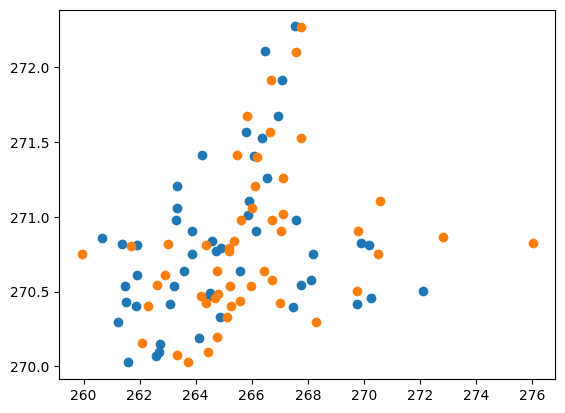

In [ ]:
# Evaluate the model
loss, mse = model.evaluate(x_test, y_test, verbose=0)
print(f"Test MSE: {mse:.4f}")

# Make predictions
predictions = model.predict(x_test)

# Calculate Mean Absolute Error (Optional additional metric)
mae = np.mean(np.abs(y_test - predictions.flatten()))
print(f"Test MAE: {mae:.4f}")

# Optional: Compare predictions with ground truth
for i in range(50):  # Print first 5 predictions for sanity check
    print(f"True: {y_test[i]:.4f}, Predicted: {predictions[i][0]:.4f}")


# Optional: Compare predictions with ground truth
for i in range(200,250):  # Print first 5 predictions for sanity check
    print(f"True: 2 {y_test[i]:.4f}, Predicted: {predictions[i][0]:.4f}")

plt.scatter(y_test[:50],predictions[:50])
plt.scatter(y_test[200:250],predictions[200:250])


[ -9.3443271   -9.36404178  -8.66469867  -9.79947233  -9.74930197
  -8.90783159 -10.34982104  -8.85199175  -8.86340531 -11.70161499
  -9.7024897   -8.20074929  -4.74630661 -10.42373852 -10.84634514
  -8.30474959  -4.31863329   2.75650462 -11.65219644 -10.20611241
 -10.21172728 -10.00021513  -9.15527805  -9.24514675 -10.25040391
  -9.95999114 -10.4068035  -11.08718921  -9.15817007 -11.32293907
 -11.16221528  -5.19483599   4.63707993  -3.49114955 -11.64070488
   4.16817852  -5.86310288  -7.79952622  -9.43023622  -8.87142781
  -8.46145381  -9.21117864  -8.84478466 -10.09222665  -8.48751788
  -9.82885496 -10.02220396 -10.14841157 -11.0847805   -5.29788342
  -4.41104109  -2.10982976   2.40710259   4.42525827  -7.05383041
  -9.01400298  -8.93761939  -7.38460601  -6.56265663  -7.41360362
  -9.11845469  -9.38168525  -9.16342263  -8.68478125  -8.16115039
  -8.88769058  -9.52050436  -9.53184321  -9.1521896   -8.32873731
  -9.42171915  -7.86590533 -10.53197808   2.80820103  -2.47729422
  -6.18744

,a1,a2,true,pred,mean
0,-9.344327,-2.846279,261.68970,271.034027,264.535979
1,-9.364042,-3.020199,261.51578,270.879822,264.535979
2,-8.664699,-2.446039,262.08994,270.754639,264.535979
3,-9.799472,-3.702059,260.83392,270.633392,264.535979
4,-9.749302,-3.762759,260.77322,270.522522,264.535979
...,...,...,...,...,...
195,-8.044890,-0.218839,264.31714,272.362030,264.535979
196,-0.950562,7.340821,271.87680,272.827362,264.535979
197,-4.298394,4.592721,269.12870,273.427094,264.535979
198,-2.332884,7.175601,271.71158,274.044464,264.535979


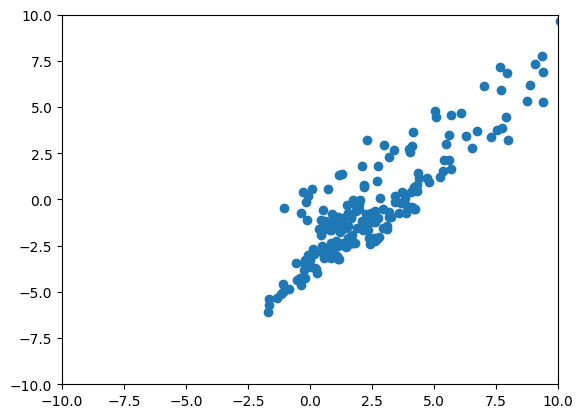

In [198]:

tt=200
k=8
print( (y_test[k*200:k*200+tt].flatten()-predictions[k*200:k*200+tt].flatten()))
a1 = (y_test[k*200:k*200+tt].flatten()-predictions[k*200:k*200+tt].flatten())
print(y_test[:tt]-np.mean(y_test[200*k:200*k+200]))

a2 = y_test[k*200:k*200+tt]-np.mean(y_test[200*k:200*k+200])

plt.scatter(a1+10,a2)
plt.ylim(-10,10)
plt.xlim(-10,10)

a3 = pd.DataFrame( {'a1':a1,'a2':a2, 'true':y_test[k*200:k*200+tt],'pred':predictions[k*200:k*200+tt].flatten(),'mean':np.mean(y_test[200*k:200*k+200])})
a3


#  lightgbm

In [241]:
x_train_2d = np.array(x_train).reshape(x_train.shape[0], -1)

# Define the best hyperparameters from cross-validation

best_params = {
    'objective': 'regression',
    'metric': 'mse',
    'num_leaves': 31,           # Increase for more splits
    'min_data_in_leaf': 15,     # Adjust for dense data
    'learning_rate': 0.01,      # Lower learning rate for better convergence
    'lambda_l1': 0.1,           # Regularization to prevent overfitting
    'lambda_l2': 0.5,           # Regularization for dense data
    'feature_fraction': 0.8,    # Use only 80% of features per split
    'bagging_fraction': 0.8,    # Use only 80% of data for bagging
    'bagging_freq': 5,          # Perform bagging every 5 iterations
    'max_depth': 12,            # Adjust depth for complexity
    'random_state': 42,
    'verbose': -1
}

# Create the full LightGBM dataset
full_train_dataset = lgb.Dataset(x_train_2d, label=y_train)

# Define a logging callback
callbacks = [lgb.log_evaluation(period=50)]

# Train the model on the full training set
final_model = lgb.train(
    best_params,
    full_train_dataset,
    num_boost_round=2000,  # Use a high value to allow full convergence
    valid_sets=[full_train_dataset],  # round 2000 to 5000 not helpful
    valid_names=['train'],
    callbacks=callbacks  # Use callbacks for logging
)

# Save the model for future use
final_model.save_model('final_model.txt')

[50]	train's l2: 21.8551
[100]	train's l2: 18.0007
[150]	train's l2: 15.7885
[200]	train's l2: 14.4701
[250]	train's l2: 13.5881
[300]	train's l2: 12.9635
[350]	train's l2: 12.5628
[400]	train's l2: 12.2847
[450]	train's l2: 12.0795
[500]	train's l2: 11.916
[550]	train's l2: 11.7962
[600]	train's l2: 11.7006
[650]	train's l2: 11.6157
[700]	train's l2: 11.5509
[750]	train's l2: 11.4973
[800]	train's l2: 11.4543
[850]	train's l2: 11.4186
[900]	train's l2: 11.3881
[950]	train's l2: 11.3465
[1000]	train's l2: 11.3236
[1050]	train's l2: 11.2969
[1100]	train's l2: 11.2757
[1150]	train's l2: 11.2583
[1200]	train's l2: 11.2324
[1250]	train's l2: 11.2113
[1300]	train's l2: 11.195
[1350]	train's l2: 11.1778
[1400]	train's l2: 11.1612
[1450]	train's l2: 11.1469
[1500]	train's l2: 11.131
[1550]	train's l2: 11.1152
[1600]	train's l2: 11.1056
[1650]	train's l2: 11.0896
[1700]	train's l2: 11.0759
[1750]	train's l2: 11.0655
[1800]	train's l2: 11.0552
[1850]	train's l2: 11.0435
[1900]	train's l2: 11.03

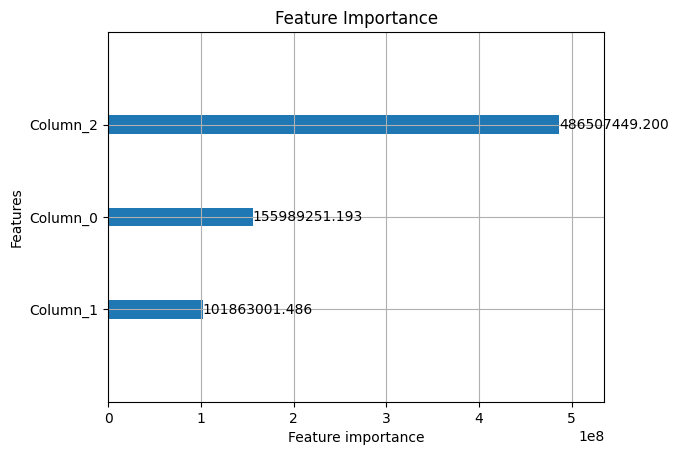

In [242]:
lgb.plot_importance(final_model, max_num_features=30, importance_type='gain')
plt.title("Feature Importance")
plt.show()

In [ ]:
4. Spatial Heterogeneity
Issue: Spatially dense datasets might introduce new heterogeneities or complex local variations that were not present in the less dense dataset.
Effect: The model may fail to capture these variations effectively, leading to poor performance.
Solution:
ConvLSTM2D
Use spatially aware models like Gaussian Processes or Spatial Boosting, which account for spatial heterogeneity explicitly.

In [249]:
a = tuple([1,2,3])
a[1]

2

In [243]:

from sklearn.metrics import mean_squared_error

# Reshape test data
test_x = np.array(x_test).reshape(x_test.shape[0], -1)

# Predict probabilities using the model
test_pred = final_model.predict(test_x)

# Calculate Mean Squared Error (MSE)
test_mse = mean_squared_error(y_test, test_pred)

# Print the MSE
print(f"Test data, probability prediction MSE: {test_mse:.4f}")
# 15 when selected ::10  


Test data, probability prediction MSE: 57.9553


In [240]:
ddd = pd.DataFrame({'pred':test_pred,'test_y':y_test, 'pred_cnn':predictions.flatten()})


ddd1 = ddd['test_y']-ddd['pred']
ddd2 = ddd['test_y']-predictions.flatten()

plt.scatter(ddd1,ddd2+10)
plt.ylim(-10,10)
plt.xlim(-10,10)
print(np.var(ddd1))
print(np.var(ddd2))

ValueError: All arrays must be of the same length